# Exact simulation of a three level system: rubidium 87

The following levels or the rubidium87 are considered:

- $\ket{g}$ = 5s1/2 : ground
- $\ket{i}$ = 6p3/2 : intermediate
- $\ket{r}$ = 70s1/2 : rydberg

so the hamiltonian of the atom is
$$ H_0 = 
\begin{pmatrix}
  \hbar \omega_g & 0 & 0 \\
  0 & \hbar \omega_i & 0\\ 
  0 & 0&  \hbar\omega_r 
\end{pmatrix} $$

the hamiltonian of the laser is
$$ H_L = \hbar \omega_L a^+ a $$

the states of the system in the $\varepsilon_N$ manifold are:
- $\ket{g, N_r+1, N_b+1}$ with energy $E_0 = 0$.
- $\ket{i, N_r+1, N_b}$ with energy $- \Delta$.
- $\ket{r, N_r, N_b}$ with energy $- \delta$.

the dressed-atom hamiltonian is
$$ H = \hbar
\begin{pmatrix}
    0 & \Omega_b/2 & 0 \\
    \Omega_b/2 & - \Delta &  \Omega_{IR}/2 \\
    0 & \Omega_{IR}/2 & - \delta 
\end{pmatrix}
$$

if we add also the depumping beam, than we have the following dressed states:
- $\ket{g, N_r+1, N_b+1, N_d}$ with energy $E_0 = 0$.
- $\ket{i, N_r+1, N_b, N_d}$ with energy $- \Delta$.
- $\ket{r, N_r, N_b, N_d}$ with energy $- \delta$.
- $\ket{i, N_r, N_b, N_d+1}$ with energy $- \delta$.

$$ H = \hbar
\begin{pmatrix}
    0 & \Omega_b/2 & 0 & 0 \\
    \Omega_b/2 & - \Delta &  \Omega_{IR}/2 & 0\\
    0 & \Omega_{IR}/2 & - \delta & \Omega_{d}/2 \\
    0 & 0 & \Omega_{d}/2 & -\delta 
\end{pmatrix}
$$

so the dynamics of the system is described by the von newman equation:
$$ \dot{\rho} = -\frac{i}{\hbar}[H,\rho] $$

considering also the spontaneous emission and/or other interaction with the enviroment this equation become
$$ \dot{\rho} = -\frac{i}{\hbar}[H,\rho] + \sum_i L(J_i, \rho) $$

where $J_i$ are the jump operators and
$$ L(J_i, \rho) = J_i \rho J_i^+ - \frac{1}{2}(J_i^+ J_i \rho + \rho J_i^+ J_i) $$

so
$$ \dot{\rho} = -\frac{i}{\hbar}[H,\rho] + L(\sqrt{\Gamma_r}S_{ri}, \rho) + L(\sqrt{\Gamma_i}S_{ig}, \rho) + L(\sqrt{\gamma_r}S_{rr}, \rho) + L(\sqrt{\gamma_i}S_{ii}, \rho) $$

where $ S_{ab} = \ket{a}\bra{b} $ and $ \Gamma_r, \Gamma_i, \gamma_r, \gamma_i $ are respectively the stontaneus emission rates and the dephasing rates.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar
from sympy import Matrix
from scipy.integrate import solve_ivp
from arc.alkali_atom_functions import AlkaliAtom
from IPython.display import clear_output
import arc
import qutip as qtp

In [251]:
Om_b = 10
Om_r = 3
Om_d = 0
Delta = 1000
delta = 0

Om_b = 30
Om_r = 2
Om_d = 0
Delta = 100
delta = 0

N_atoms_in_interaction_volume = 1
N_states = 4

steps = 1000
time = 10
times = np.linspace(0, time, steps)

def H():
    return np.array([
    [0, Om_b/2, 0, 0],
    [Om_b/2, -Delta, Om_r/2, 0],
    [0, Om_r/2, -delta, Om_d/2],
    [0, 0, Om_d/2, -delta]
])

psi0 = np.zeros([4,4])
psi0[2,2] = 1

# jump operators
Gamma_i = 8
Gamma_ry = 0.002
def_ry = 0
def_i = 0

S_minus_i = qtp.Qobj(Gamma_i**(1/2)*(np.array([[0,1,0,1],[0,0,0,0],[0,0,0,0],[0,0,0,0]])))
S_minus_ry = qtp.Qobj(Gamma_ry**(1/2)*np.array([[0,0,1,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
J_def_i = qtp.Qobj(def_i**(1/2)*np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,1]]))
J_def_ry = qtp.Qobj(def_ry**(1/2)*np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]]))

Jump_ops = [S_minus_i, S_minus_ry, J_def_ry, J_def_i]

In [252]:
result = qtp.mesolve(qtp.Qobj(H()), qtp.Qobj(psi0), times, c_ops = Jump_ops)

In [253]:
def projector(a,b):
    projector_ = np.zeros([N_states, N_states])
    projector_[a,b] = 1
    return projector_

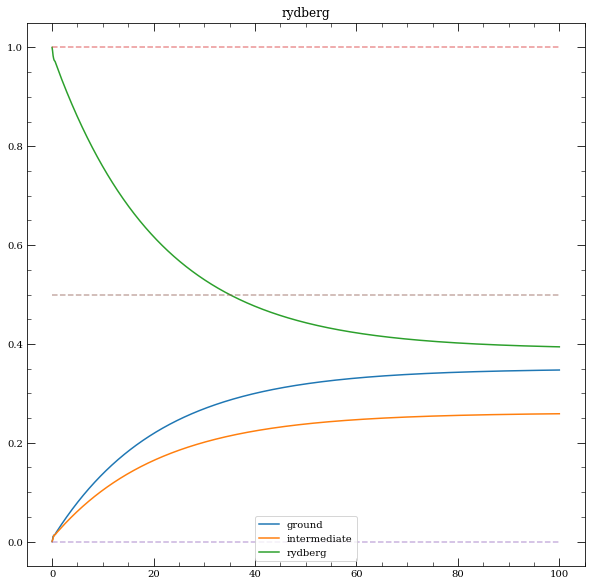

In [254]:
evo = [np.array(result.states[i]) for i in range(steps)]
p_trace_res = {}
labels = ["ground","intermediate","rydberg"]
for l, label in enumerate(labels):
    if l==1: projector_ = projector(1,1) + projector(3,3)
    else: projector_ = projector(l,l)
    p_trace_res[label] = [N_atoms_in_interaction_volume * np.trace(np.dot(evo[i], projector_)) for i in range(steps)]
plt.figure(figsize=(10,10))

for i, label in enumerate(labels):
    plt.plot(times, p_trace_res[label], label=label)
plt.plot([0,times[-1]],[N_atoms_in_interaction_volume,N_atoms_in_interaction_volume],"--", alpha=0.5)
plt.plot([0,times[-1]],[0,0],"--", alpha=0.5)
plt.plot([0,times[-1]],[N_atoms_in_interaction_volume/2,N_atoms_in_interaction_volume/2],"--", alpha=0.5)
plt.ylim([-0.05,1.05])
plt.title(label)
plt.legend()

plt.show()

Try to see EIT with this model

In [279]:
Om_b = 30
Om_r = 2
Om_d = 0
Delta = 0
delta = 0
N_states = 4

steps = 1000
time = 20
times = np.linspace(0, time, steps)

psi0 = np.zeros([4,4])
psi0[2,2] = 1

# jump operators
Gamma_i = 8
Gamma_ry = 0.001
def_ry = 5
def_i = 0

S_minus_i = qtp.Qobj(Gamma_i**(1/2)*(np.array([[0,1,0,1],[0,0,0,0],[0,0,0,0],[0,0,0,0]])))
S_minus_ry = qtp.Qobj(Gamma_ry**(1/2)*np.array([[0,0,1,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]))
J_def_i = qtp.Qobj(def_i**(1/2)*np.array([[0,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,1]]))
J_def_ry = qtp.Qobj(def_ry**(1/2)*np.array([[0,0,0,0],[0,0,0,0],[0,0,1,0],[0,0,0,0]]))

Jump_ops = [S_minus_i, S_minus_ry, J_def_ry, J_def_i]

In [280]:
result = qtp.mesolve(qtp.Qobj(H()), qtp.Qobj(psi0), times, c_ops = Jump_ops)

In [281]:
N_points = 100
deltas = np.linspace(-200,200,N_points)
results = []
for i, Delta in enumerate(deltas):
    clear_output(wait=True)
    print("status: %.1f %%"%((i+1)/N_points*100))
    delta = Delta
    result = qtp.mesolve(qtp.Qobj(H()), qtp.Qobj(psi0), times, c_ops = Jump_ops)
    results.append(result.states[-1])

status: 100.0 %


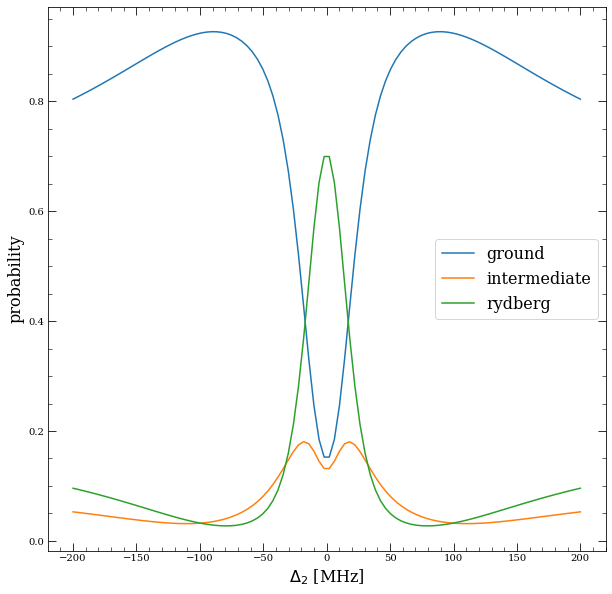

In [282]:
populations = {}
for l, label in enumerate(labels):
    populations[label] = [np.trace(np.dot(results[i],projector(l,l))) for i in range(N_points)]

plt.figure(figsize=(10,10))
for l, label in enumerate(labels):
    plt.plot(deltas, populations[label], label = labels[l])
plt.xlabel("$\Delta_2$ [MHz]", fontsize=16)
plt.ylabel("probability", fontsize=16)
plt.legend(fontsize=16)
plt.show()